# Import Libraries

In [98]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords


In [99]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yogesh/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Data Prepration

In [62]:
train_df = pd.read_csv('train_data.csv')[['New_Sentence', 'Type']]
test_df = pd.read_csv('test_data.csv')

<AxesSubplot: >

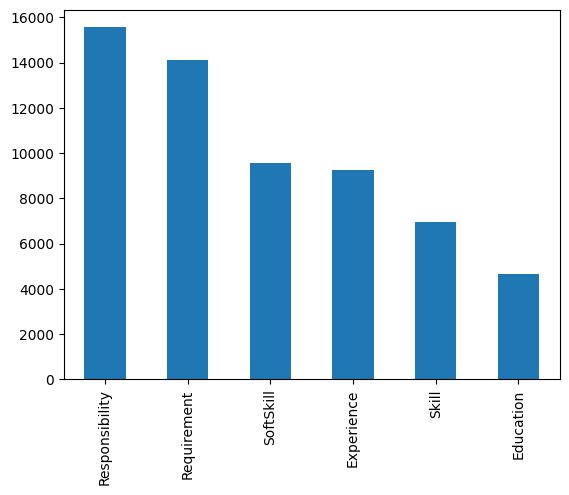

In [63]:
train_df.Type.value_counts().plot(kind='bar')

## Data Preprocessing

## Remove invalid(Na) sentences

In [64]:
train_df.isna().sum()

New_Sentence    1113
Type               0
dtype: int64

In [65]:
train_df = train_df.dropna()

## Data split

In [70]:
raw_train_x,train_y,raw_dev_x,dev_y = train_test_split( train_df.New_Sentence, train_df.Type, test_size=0.2,stratify=train_df.Type, random_state=2)

## Data Processing

In [100]:
train_x = raw_train_x.apply(lambda x:x.lower())
train_x = train_x.apply(lambda x:re.sub(r'[^\w\s]','',x))
train_x = train_x.apply(lambda x:x.split())
# train_x = train_x.apply(lambda x: [word for word in x if word not in stopwords.words('english')])

In [101]:
vocab = Counter()
for words in train_x.tolist():
    vocab.update(words)

In [104]:
## remove rare words
min_theshold = 5
vocab = {word: count for word,count in vocab.items() if count>=min_theshold}

## remove stop words
vocab = {word: count for word,count in vocab.items() if word not in stopwords.words('english')}

In [113]:
vocab

{'experience': 12891,
 '10': 659,
 '12': 194,
 'years': 6502,
 'efficient': 80,
 'accurate': 98,
 'management': 3741,
 'building': 526,
 'information': 778,
 'models': 163,
 'defined': 82,
 'standards': 388,
 'meet': 358,
 'contractual': 103,
 'requirements': 1255,
 'honeywell': 795,
 'projects': 1303,
 'must': 1731,
 'lead': 923,
 'total': 83,
 'solution': 504,
 'selling': 193,
 'combustion': 13,
 'systems': 1747,
 'possible': 44,
 'also': 205,
 'importance': 11,
 'component': 82,
 'sales': 1340,
 'complete': 154,
 'system': 971,
 'demonstrated': 718,
 'ability': 3880,
 'drive': 850,
 'change': 438,
 'build': 428,
 'performance': 717,
 'culture': 88,
 'excellent': 1108,
 'programming': 309,
 'java': 399,
 'familiarity': 170,
 'stages': 27,
 'sdlc': 72,
 'lifecycle': 177,
 'working': 1825,
 'large': 403,
 'enterprise': 386,
 'environment': 1317,
 'supporting': 258,
 'design': 1997,
 'development': 2625,
 'deployment': 208,
 'define': 220,
 'identification': 63,
 'reconciliation': 26,
 